In [4]:
import sys
import os
from dotenv import load_dotenv
load_dotenv()

True

Módulos importados com sucesso!

--- INICIANDO ANÁLISE DA DISTRIBUIÇÃO DO PIB TOTAL (AGREGADO) POR REGIÃO ---

Análise 1: Histograma dos PIBs Totais por Região (Original)
Gerando histograma da distribuição dos PIBs totais, separado por região...


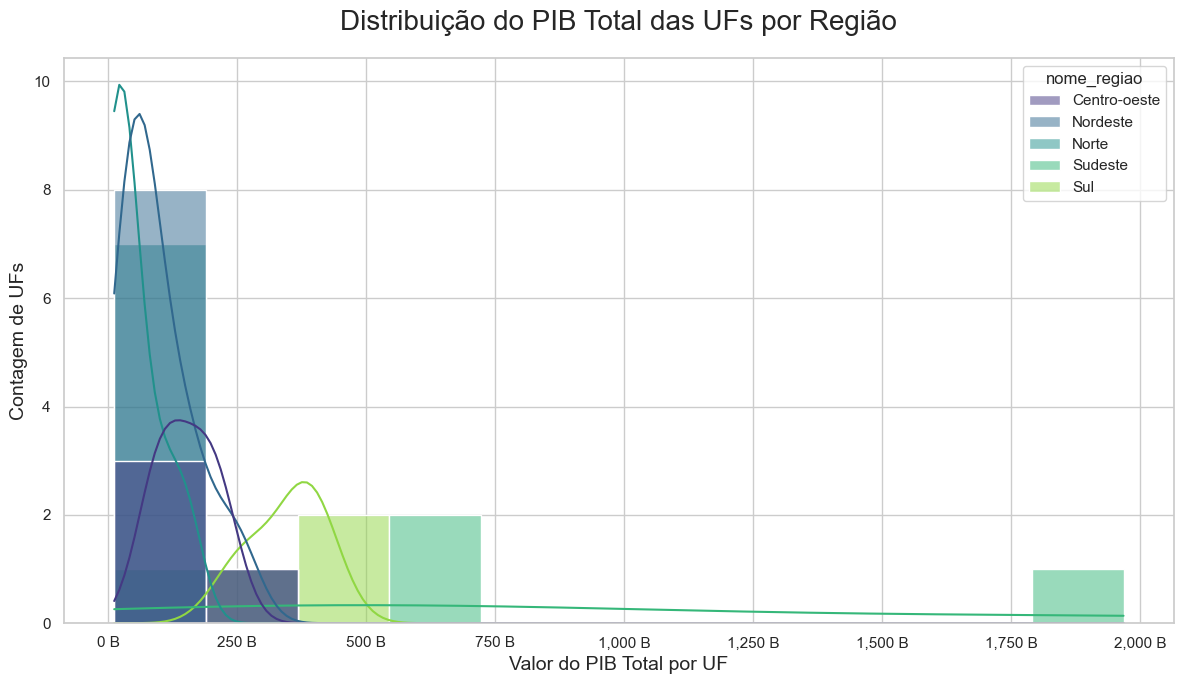


Análise 2: Histograma dos PIBs Totais por Região (Log)
Gerando histograma da distribuição dos PIBs totais (escala log), separado por região...


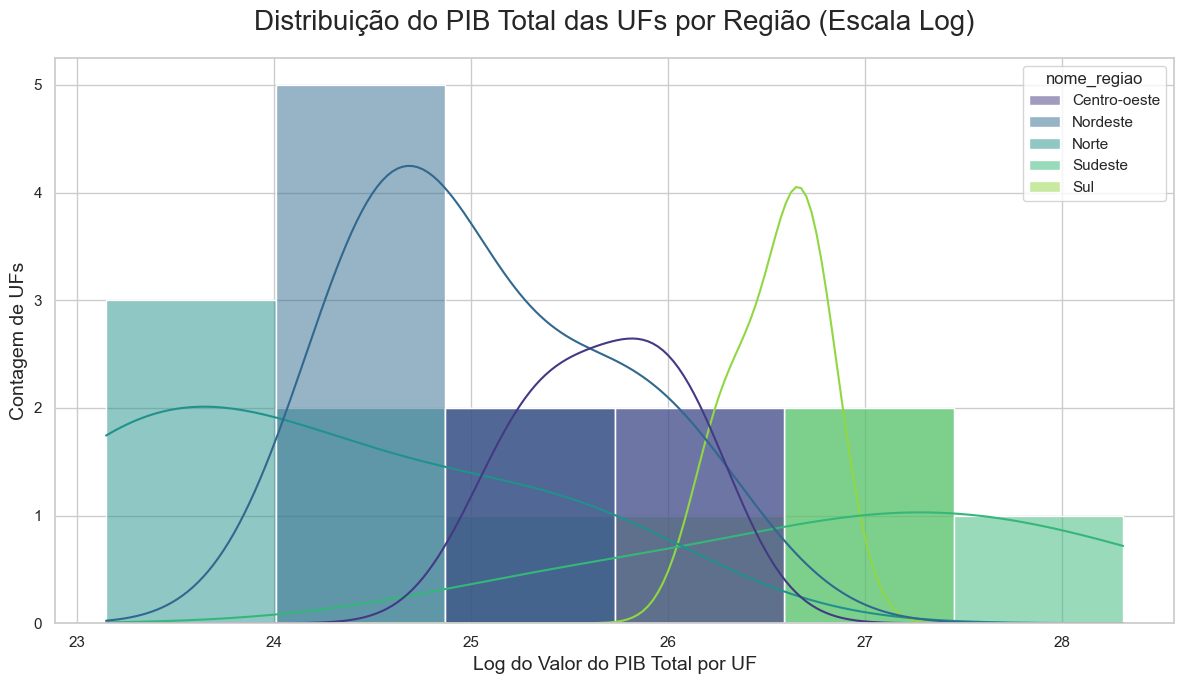


--- INICIANDO ANÁLISE DA DISTRIBUIÇÃO MUNICIPAL ---

Análise 3: Distribuição do PIB Municipal por UF (Original)


c:\Users\Deivyson Henrique\Desktop\outliers\src\load.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=dataframe, x='nome_uf', y='pib', order=uf_order, palette='viridis')


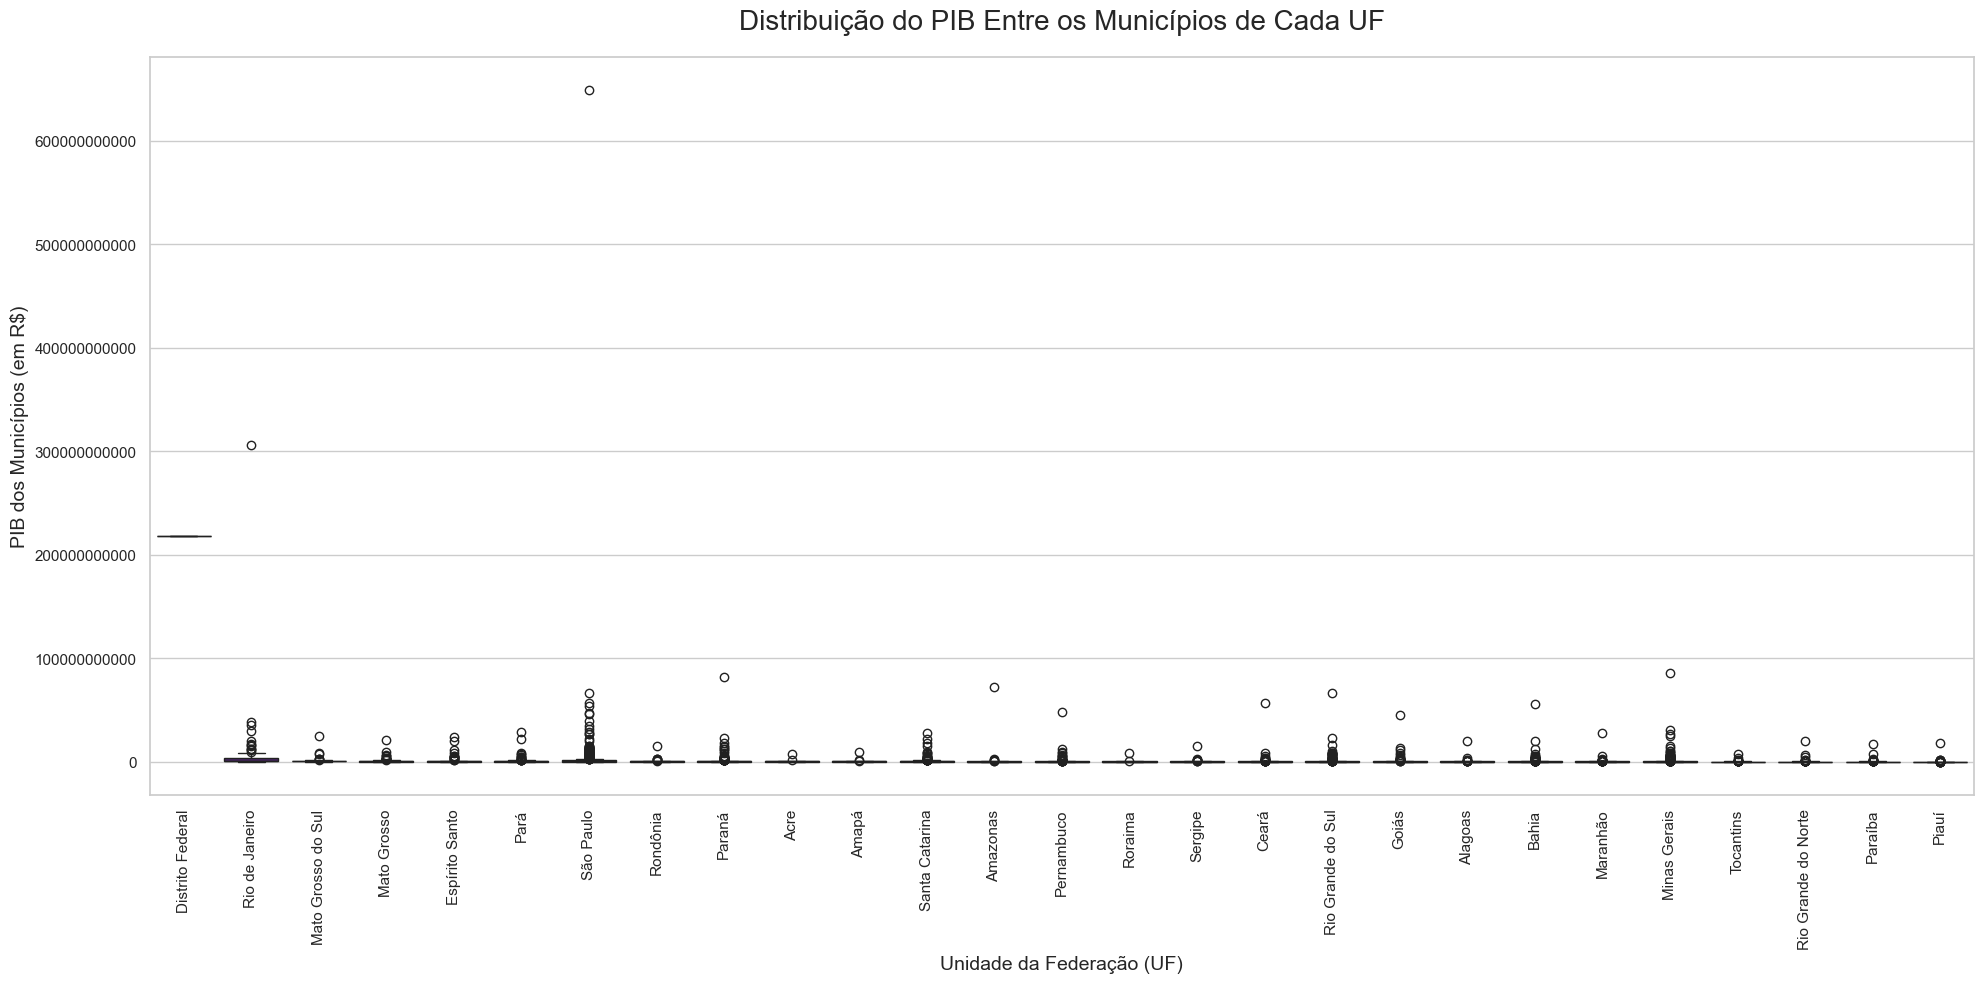


Análise 4: Distribuição do PIB Municipal por UF (Pós-Transformação Log)
Gerando boxplot da distribuição municipal com dados transformados...


c:\Users\Deivyson Henrique\Desktop\outliers\src\load.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=dataframe, x='nome_uf', y='pib_log', order=uf_order, palette='plasma')


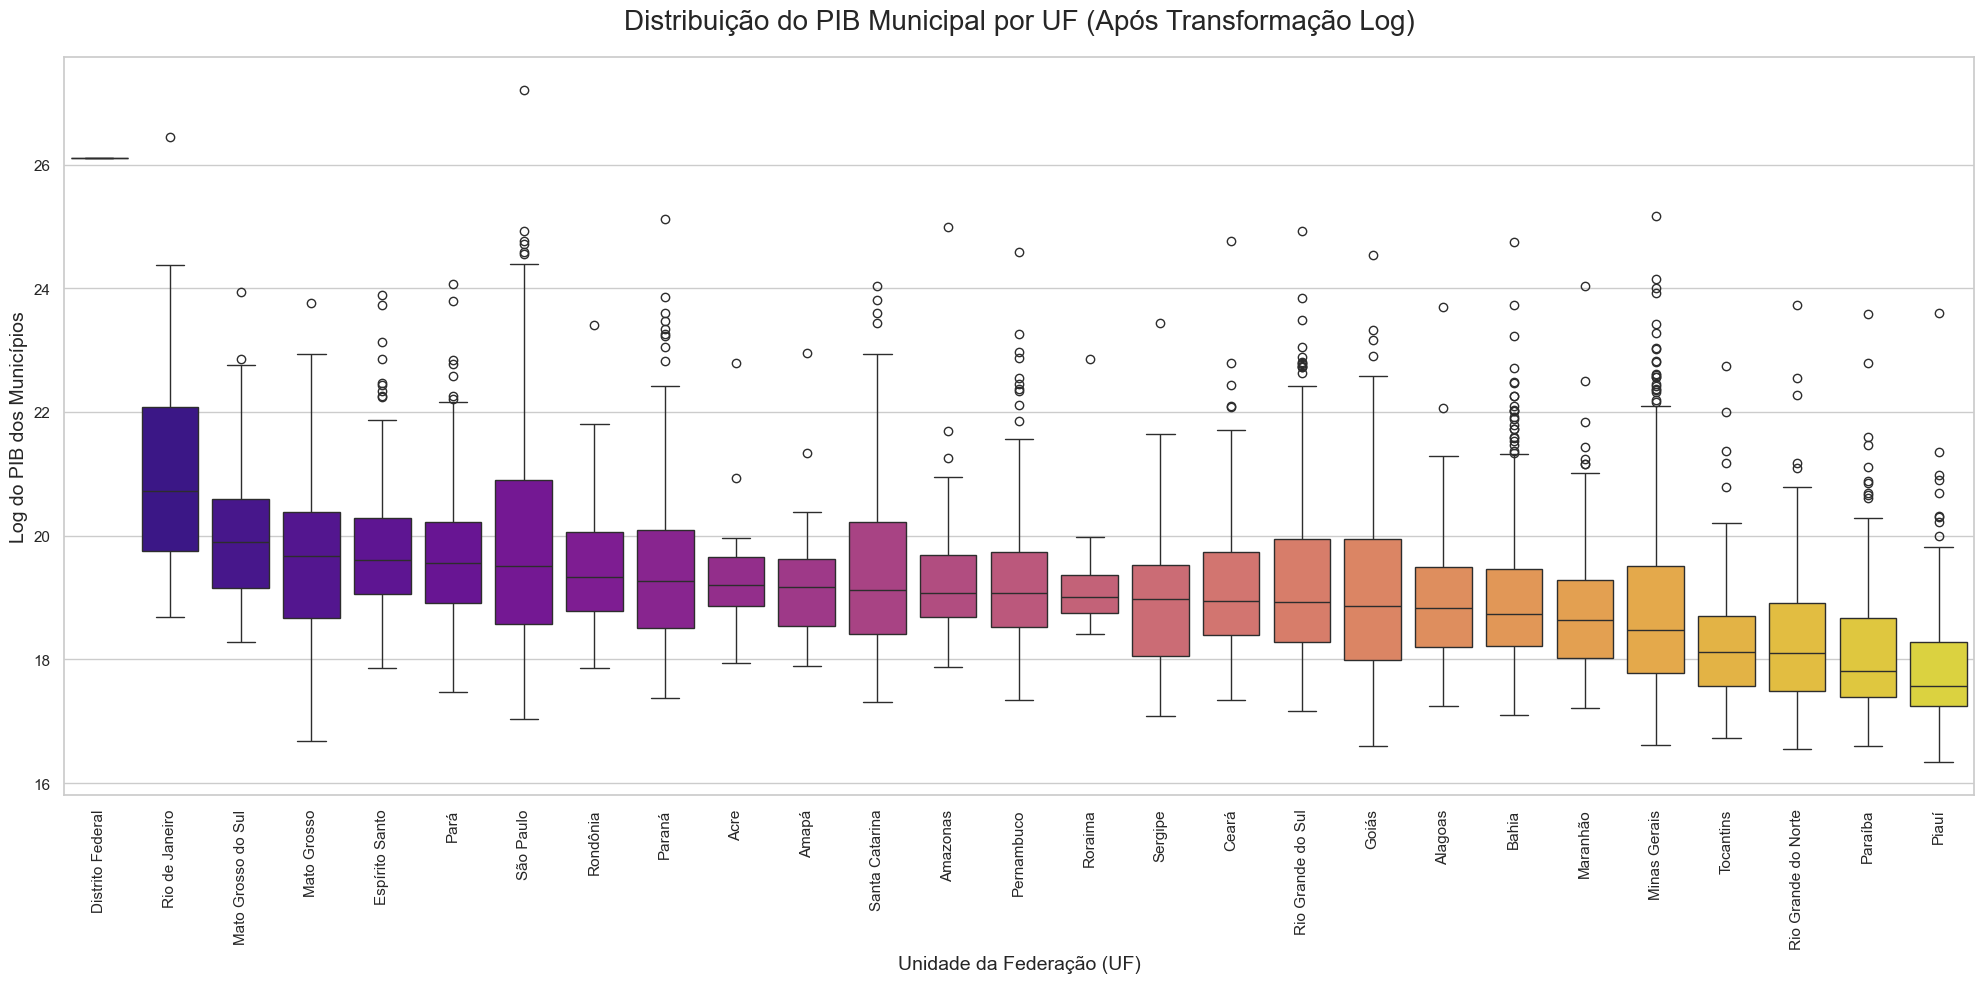

In [ ]:
#IQR
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.transform import obter_dados_processados
from src.load import executar_analise_completa

print("Módulos importados com sucesso!")

nome_do_arquivo = os.getenv('ARCHIVE_PATH')
caminho_do_arquivo = os.path.join(project_root, nome_do_arquivo)#type: ignore

df_final, df_outliers_zscore, df_outliers_iforest = obter_dados_processados(caminho_do_arquivo)

if df_final is not None:
    executar_analise_completa(df_final)

In [ ]:
#z-score
from src.load import apresentar_analise_zscore
if df_outliers_zscore is not None:
    apresentar_analise_zscore(df_outliers_zscore)


Análise de Outliers pelo Método Z-Score (Limiar |Z| > 3)
Municípios identificados como outliers em 'pib' ou 'pib_per_capta':
                       nome_mun             nome_uf           pib  pib_zscore  pib_per_capta  pib_per_capta_zscore
4296                  São Paulo           São Paulo  6.487623e+11       60.33   54240.349167                  1.58
3709             Rio de Janeiro      Rio de Janeiro  3.059363e+11       28.39   46710.282500                  1.23
466                    Brasília    Distrito Federal  2.177734e+11       20.18   74954.880000                  2.57
2776             Belo Horizonte        Minas Gerais  8.558901e+10        7.87   34451.918333                  0.64
4472                   Curitiba              Paraná  8.145110e+10        7.48   43387.190000                  1.07
2372                     Manaus            Amazonas  7.173426e+10        6.58   34696.084167                  0.65
5398               Porto Alegre   Rio Grande do Sul  6.652926e+10    


Análise de Outliers pelo Método Isolation Forest


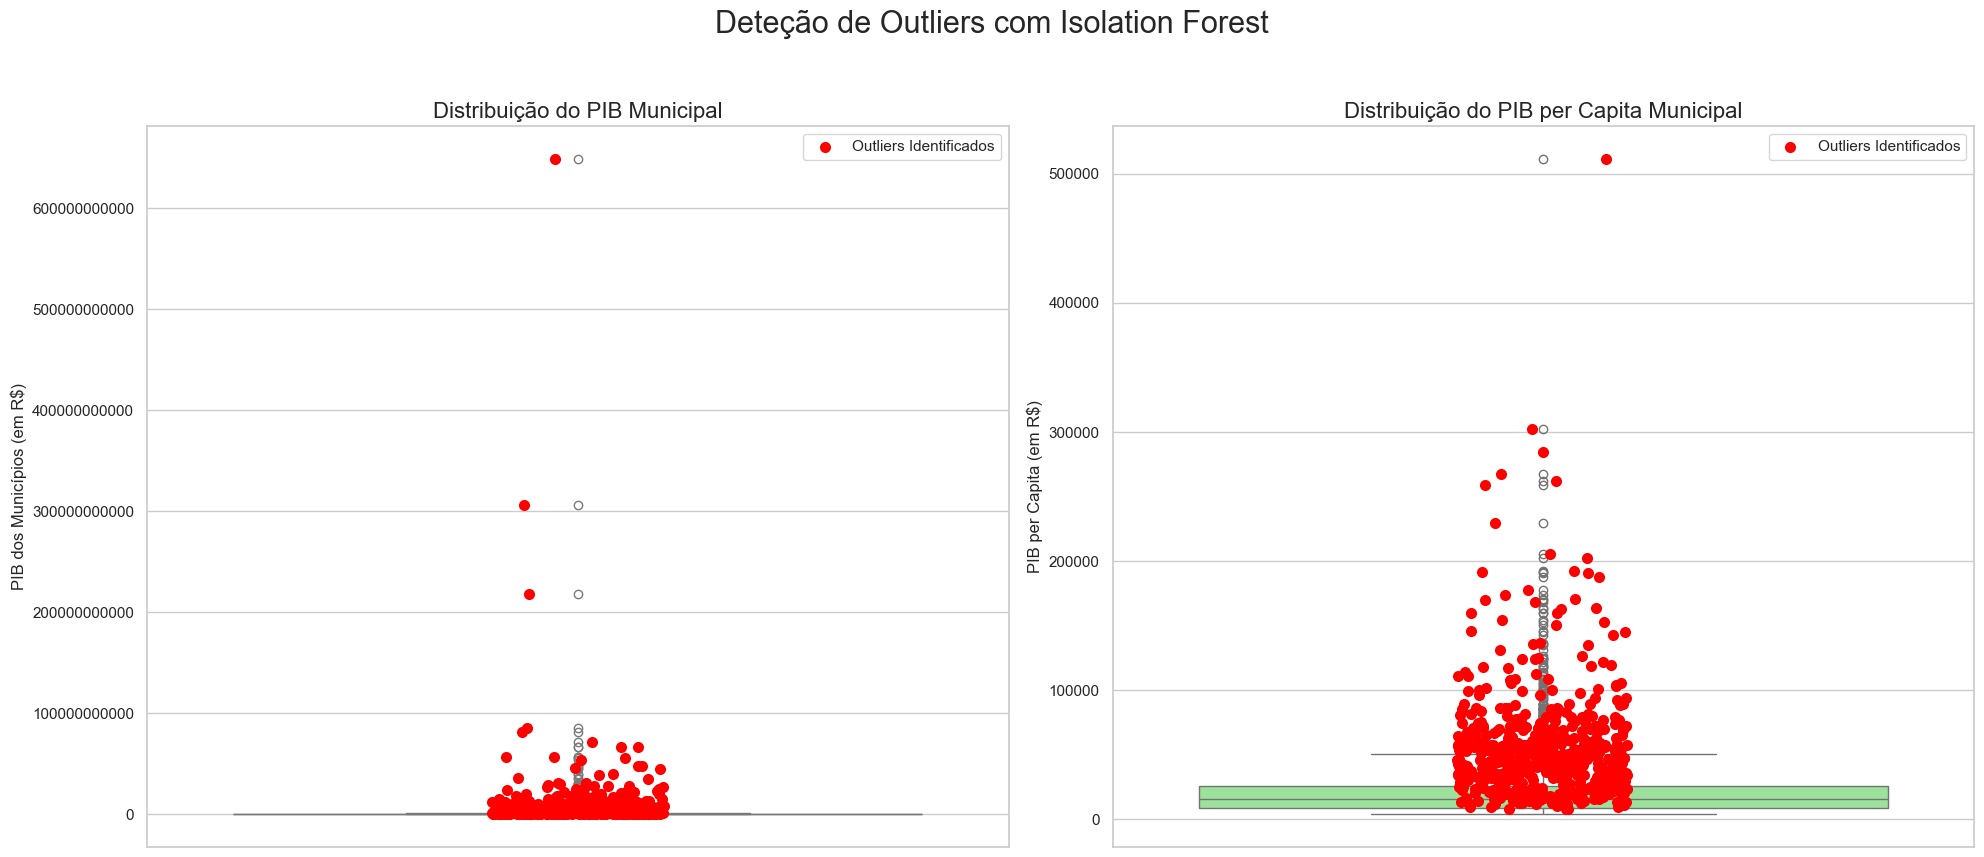

In [16]:
# isolation forest
from src.load import plotar_outliers_isolation_forest
if df_final is not None and df_outliers_iforest is not None:
    plotar_outliers_isolation_forest(df_final, df_outliers_iforest)

# Análise Comparativa de Outliers e Contexto Socioeconómico

**Objetivo:** Esta análise busca: 

1.  Comparar os resultados dos três métodos de deteção de outliers implementados: **Intervalo Interquartil (IQR)**, **Z-Score** e **Isolation Forest**.
2.  Identificar os municípios que são consistentemente classificados como anomalias, com foco no `pib_per_capta`.
3.  Investigar o contexto socioeconómico destes municípios para entender as causas da sua discrepância.
4.  Discutir o impacto destes outliers na interpretação de indicadores nacionais e na formulação de políticas públicas.

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from sklearn.ensemble import IsolationForest
import warnings

# Ignorar avisos para uma apresentação mais limpa
warnings.filterwarnings('ignore')

# Configurações de visualização
sns.set_theme(style="whitegrid")
pd.set_option('display.max_rows', 100)

print("Ambiente configurado com sucesso.")

Ambiente configurado com sucesso.


In [18]:

# --- Método 1: Identificar Outliers com IQR ---
def identificar_outliers_iqr(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_superior = Q3 + 1.5 * IQR
    outliers = df[df[coluna] > limite_superior]
    return outliers

# --- Método 2: Identificar Outliers com Z-Score ---
def identificar_outliers_zscore(df, coluna, threshold=3):
    media = df[coluna].mean()
    desvio_padrao = df[coluna].std()
    df['zscore'] = (df[coluna] - media) / desvio_padrao
    outliers = df[np.abs(df['zscore']) > threshold]
    return outliers.drop(columns=['zscore'])

# --- Método 3: Identificar Outliers com Isolation Forest ---
def identificar_outliers_iforest(df, coluna, random_state=42):
    X = df[[coluna]]
    model = IsolationForest(contamination='auto', random_state=random_state)
    previsoes = model.fit_predict(X)
    outliers = df[previsoes == -1]
    return outliers

# Aplicar os métodos na coluna 'pib_per_capta'
coluna_alvo = 'pib_per_capta'

outliers_iqr = identificar_outliers_iqr(df_final, coluna_alvo)
outliers_zscore = identificar_outliers_zscore(df_final, coluna_alvo)
outliers_iforest = identificar_outliers_iforest(df_final, coluna_alvo)

print(f"Outliers encontrados com IQR: {len(outliers_iqr)}")
print(f"Outliers encontrados com Z-Score (|Z|>3): {len(outliers_zscore)}")
print(f"Outliers encontrados com Isolation Forest: {len(outliers_iforest)}")

# Extrair os códigos únicos dos municípios para comparação
set_iqr = set(outliers_iqr['cod_mun'])
set_zscore = set(outliers_zscore['cod_mun'])
set_iforest = set(outliers_iforest['cod_mun'])

Outliers encontrados com IQR: 275
Outliers encontrados com Z-Score (|Z|>3): 81
Outliers encontrados com Isolation Forest: 769


Tabela Comparativa de Outliers (pib_per_capta)


,nome_mun,nome_uf,pib_per_capta,IQR,Z-Score,Isolation Forest
3622,Presidente Kennedy,Espírito Santo,511359.633333,True,True,True
3432,São Gonçalo do Rio Abaixo,Minas Gerais,302545.570000,True,True,True
71,Selvíria,Mato Grosso do Sul,284959.661667,True,True,True
4042,Louveira,São Paulo,267225.612500,True,True,True
5535,Triunfo,Rio Grande do Sul,262219.537500,True,True,True
...,...,...,...,...,...,...
635,Santo Amaro do Maranhão,Maranhão,4300.975833,False,False,True
634,Santana do Maranhão,Maranhão,4276.610000,False,False,True
582,Matões do Norte,Maranhão,4259.795833,False,False,True
590,Nina Rodrigues,Maranhão,4170.661667,False,False,True



Visualização 1: Hierarquia dos Métodos (Círculos Concêntricos)


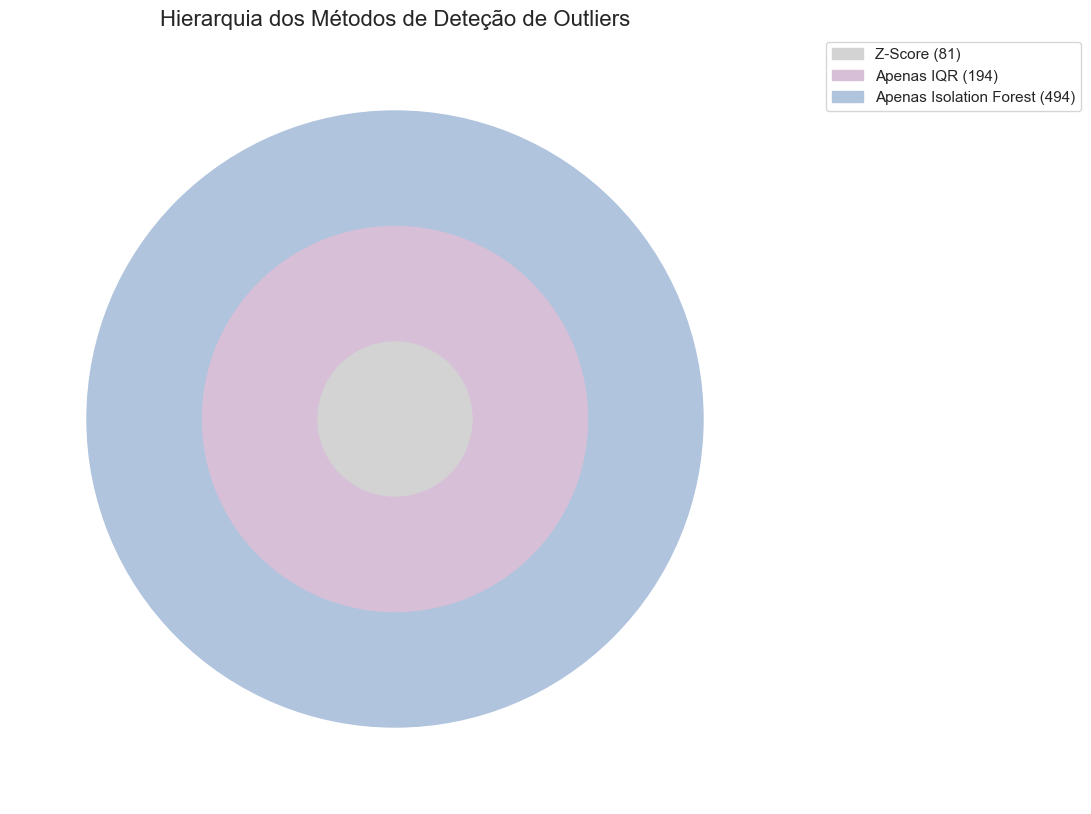

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import seaborn as sns
import pandas as pd

if (
    'df_final' in locals() and df_final is not None and
    'set_iqr' in locals() and set_iqr is not None and
    'set_zscore' in locals() and set_zscore is not None and
    'set_iforest' in locals() and set_iforest is not None
):

    todos_outliers_cod = sorted(list(set_iqr.union(set_zscore).union(set_iforest)))
    df_comparativo = df_final[df_final['cod_mun'].isin(todos_outliers_cod)].copy()
    df_comparativo['IQR'] = df_comparativo['cod_mun'].isin(set_iqr)
    df_comparativo['Z-Score'] = df_comparativo['cod_mun'].isin(set_zscore)
    df_comparativo['Isolation Forest'] = df_comparativo['cod_mun'].isin(set_iforest)
    print("Tabela Comparativa de Outliers (pib_per_capta)")
    display(df_comparativo[['nome_mun', 'nome_uf', 'pib_per_capta', 'IQR', 'Z-Score', 'Isolation Forest']].sort_values(by='pib_per_capta', ascending=False))
    

    # --- Gráfico 1: Círculos Concêntricos (Diagrama de Euler) ---
    print("\n" + "="*60)
    print("Visualização 1: Hierarquia dos Métodos (Círculos Concêntricos)")
    count_zscore = len(set_zscore)
    count_iqr_only = len(set_iqr) - len(set_zscore)
    count_iforest_only = len(set_iforest) - len(set_iqr)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_aspect('equal')
    circle_iforest = Circle((0.5, 0.5), 0.4, color='lightsteelblue', label=f'Apenas Isolation Forest ({count_iforest_only})')
    circle_iqr = Circle((0.5, 0.5), 0.25, color='thistle', label=f'Apenas IQR ({count_iqr_only})')
    circle_zscore = Circle((0.5, 0.5), 0.1, color='lightgray', label=f'Z-Score ({count_zscore})')
    ax.add_artist(circle_iforest)
    ax.add_artist(circle_iqr)
    ax.add_artist(circle_zscore)
    plt.title('Hierarquia dos Métodos de Deteção de Outliers', fontsize=16)
    plt.legend(handles=[circle_zscore, circle_iqr, circle_iforest], bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.axis('off')
    plt.show()
else:
    print("Erro: df_final ou algum dos conjuntos de outliers não foi definido.")

In [ ]:
# Selecionar os 4 municípios classificados como outliers pelos três métodos com maior PIB per capita
if df_final is not None:
	outlier_codigos = set_iqr & set_zscore & set_iforest
	municipios_selecionados = df_final[df_final['cod_mun'].isin(outlier_codigos)].sort_values(by='pib_per_capta', ascending=False).head(4)
	print("Municípios selecionados para investigação socioeconómica:")
	display(municipios_selecionados[['nome_mun', 'nome_uf', 'pib_per_capta']])
else:
	print("Erro: df_final não está definido.")

Municípios selecionados para investigação socioeconómica:


,nome_mun,nome_uf,pib_per_capta
3622,Presidente Kennedy,Espírito Santo,511359.633333
3432,São Gonçalo do Rio Abaixo,Minas Gerais,302545.570000
71,Selvíria,Mato Grosso do Sul,284959.661667
4042,Louveira,São Paulo,267225.612500


# Análise Qualitativa dos Municípios Outliers

A análise quantitativa identificou um conjunto de municípios que, segundo os três métodos, são pontos fora da curva no que diz respeito ao PIB per capita. Selecionámos os quatro principais para uma investigação contextual.

## Contexto Económico dos Municípios Selecionados

Uma breve pesquisa sobre os municípios selecionados revela um padrão claro: as suas economias são altamente especializadas e dominadas por atividades de altíssimo valor agregado, geralmente associadas a uma população relativamente pequena.

* **Canaã dos Carajás (PA):** A economia do município é quase inteiramente dependente da **mineração**. É a sede do projeto S11D da Vale, a maior mina de minério de ferro a céu aberto do mundo. A receita gerada por esta operação é colossal e, quando dividida pela sua população, resulta num PIB per capita astronómico.

* **Selvíria (MS):** O principal motor económico de Selvíria é a **geração de energia elétrica**. O município abriga uma parte significativa da Usina Hidrelétrica de Ilha Solteira, uma das maiores do país. Os royalties e a produção de energia, combinados com uma base populacional pequena, elevam o seu PIB per capita. Além disso, a região tem forte presença da indústria de celulose.

* **Paulínia (SP):** Este município é um dos principais polos **petroquímicos** da América Latina, sendo a casa da Refinaria de Paulínia (REPLAN), a maior da Petrobras em capacidade de processamento. A atividade industrial de refino de petróleo e produção de derivados gera uma receita massiva para a cidade.

* **São Gonçalo do Amarante (CE):** O elevado PIB per capita deste município foi impulsionado pela instalação de grandes projetos industriais no **Complexo Industrial e Portuário do Pecém**. Destaques incluem uma siderúrgica e, mais recentemente, projetos de hidrogénio verde, que atraem investimentos bilionários e geram alto valor agregado.

## Discussão e Reflexão

Discussão e Reflexão: O Impacto dos Outliers em Indicadores Agregados e Políticas Públicas
A identificação de municípios com PIB per capita extraordinariamente elevados não é apenas uma curiosidade estatística; ela expõe uma vulnerabilidade crítica no uso de indicadores agregados, como a média nacional, e tem implicações diretas na formulação de políticas públicas.

A Distorção da Média Nacional e Regional
O principal indicador de riqueza de uma região é, frequentemente, o seu PIB per capita médio. No entanto, a média aritmética é uma medida estatística extremamente sensível a valores extremos (outliers). A presença de um único ponto com valor massivamente desproporcional pode "puxar" a média para cima, criando uma representação distorcida da realidade da maioria.

Imagine calcular a renda média de um bar com dez clientes, onde nove são trabalhadores que ganham R$ 2.500 por mês e o décimo é um bilionário. A média de renda calculada será altíssima, na casa dos milhões, mas esse valor não representará a realidade de ninguém no local: nem dos nove trabalhadores, nem do bilionário. É exatamente este o fenómeno que municípios como Canaã dos Carajás (mineração) ou Paulínia (petroquímica) causam nos dados brasileiros. Eles funcionam como o "bilionário no bar".

Quando calculamos o PIB per capita médio do Brasil, ou mesmo de um estado, esses poucos municípios extraordinariamente ricos inflam artificialmente o resultado. O indicador final pode sugerir um nível de desenvolvimento e prosperidade económica que não corresponde à experiência vivida pela esmagadora maioria das cidades, que possuem economias mais tradicionais e diversificadas. A média torna-se uma ilusão estatística, escondendo a profunda desigualdade territorial que existe no país. Por isso, indicadores mais robustos a outliers, como a mediana (que representa o valor do "município do meio"), ofereceriam um retrato muito mais fiel da realidade económica típica do Brasil.

O Impacto na Formulação de Políticas Públicas
Governos e agências de fomento baseiam-se em indicadores como o PIB per capita médio para tomar decisões cruciais sobre a alocação de recursos, a criação de programas sociais e a definição de prioridades de investimento. Quando este indicador é distorcido, as consequências podem ser graves:

Alocação Incorreta de Recursos: Um estado pode apresentar um PIB per capita médio elevado devido a um ou dois municípios com royalties de petróleo ou mineração. Com base neste dado agregado, o estado pode ser classificado como "rico" e, consequentemente, receber menos transferências de verbas federais para áreas como saúde, educação e infraestrutura. No entanto, a realidade pode ser a de que, fora desses enclaves de riqueza, a maioria da população vive em condições de subdesenvolvimento. A política pública, guiada pela média, falha em alcançar as áreas que mais precisam.

Diagnósticos Socioeconómicos Equivocados: Políticas públicas eficazes dependem de um diagnóstico correto. Se a análise se baseia numa média inflacionada, a verdadeira dimensão de problemas como a pobreza, a desigualdade e a falta de oportunidades pode ser subestimada. Metas de desenvolvimento podem ser definidas de forma irrealista, e a urgência de certas intervenções pode ser ignorada.

Ineficácia de Programas Universais: Programas desenhados com base na "realidade média" podem não ser adequados nem para os municípios extremamente ricos (que podem precisar de políticas para gerir a sua riqueza e os seus impactos ambientais) nem para os municípios pobres (que precisam de investimentos básicos). A heterogeneidade, mascarada pela média, exige políticas públicas mais granulares e direcionadas.

Em suma, a análise destes outliers demonstra que uma dependência cega de indicadores agregados é perigosa. É fundamental que os decisores políticos analisem a distribuição completa dos dados, identifiquem os pontos fora da curva e compreendam as suas causas. Apenas com uma visão detalhada da desigualdade territorial é possível formular políticas públicas justas e eficazes, que atendam às necessidades reais da população em vez de serem guiadas por médias estatísticas distorcidas.